<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [ddG PSSM](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/11.01-PyData-ddG-pssm.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) |<p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/11.02-PyData-miniprotein-design.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Distributed computation example: miniprotein design

## Notes
This tutorial will walk you through how to design miniproteins in PyRosetta using the PyData stack for analysis and distributed computing.

## Citation
[Integration of the Rosetta Suite with the Python Software Stack via reproducible packaging and core programming interfaces for distributed simulation](https://doi.org/10.1002/pro.3721)

Alexander S. Ford, Brian D. Weitzner, Christopher D. Bahl

## Manual
Documentation for the `pyrosetta.distributed` namespace can be found here: https://nbviewer.jupyter.org/github/proteininnovation/Rosetta-PyData_Integration/blob/master/distributed_overview.ipynb

In [ ]:
# Notebook setup

!pip install pyrosettacolabsetup
import pyrosettacolabsetup
pyrosettacolabsetup.setup()
print ("Notebook is set for PyRosetta use in Colab.  Have fun!")

In [1]:
import pyrosetta
import pyrosetta.distributed.dask
import dask.bag
import dask.distributed

In [2]:
import pandas
import seaborn
from matplotlib import pylab

In [3]:
from pyrosetta.distributed.tasks.score import ScorePoseTask
from pyrosetta.distributed.io import pose_from_pdbstring
from pyrosetta.distributed.packed_pose import to_dict

In [4]:
import zipfile

In [ ]:
!pip install py3Dmol

In [5]:
import py3Dmol

# Init

Setup LocalCluster to full utilize the current machine.

In [6]:
cluster = dask.distributed.LocalCluster()
client = dask.distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38929 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 48 Memory: 198.49 GB


# Load 

Load decoys from batch compute run, adding annotations for designed sequence, cystine count and cystine location.

In [7]:
def load_source(decoy):
    src_pdb = zipfile.ZipFile(library).open(decoy).read()
    p = pose_from_pdbstring(src_pdb)
    
    cys_locations=[i for i, c in enumerate(p.pose.sequence()) if c == "C"]
    p = p.update_scores(
        library=library,
        decoy=decoy,
        sequence=p.pose.sequence(),
        num_res = len(p.pose.sequence()),
        num_cys=len(cys_locations),
        cys_locations=",".join(map(str, cys_locations))
    )

    return p

In [8]:
library = "EHEE_library.zip"
decoy_names = [f.filename for f in zipfile.ZipFile(library).filelist if f.filename.endswith(".pdb")]

In [9]:
decoys = dask.bag.from_sequence(decoy_names).map(load_source).map(ScorePoseTask()).persist()

In [10]:
result_frame = pandas.DataFrame.from_records(decoys.map(to_dict).compute()).sort_values("total_score")

# Analysis

We anticipate a distribution of score results, with higher scores with more disulfide insertions.

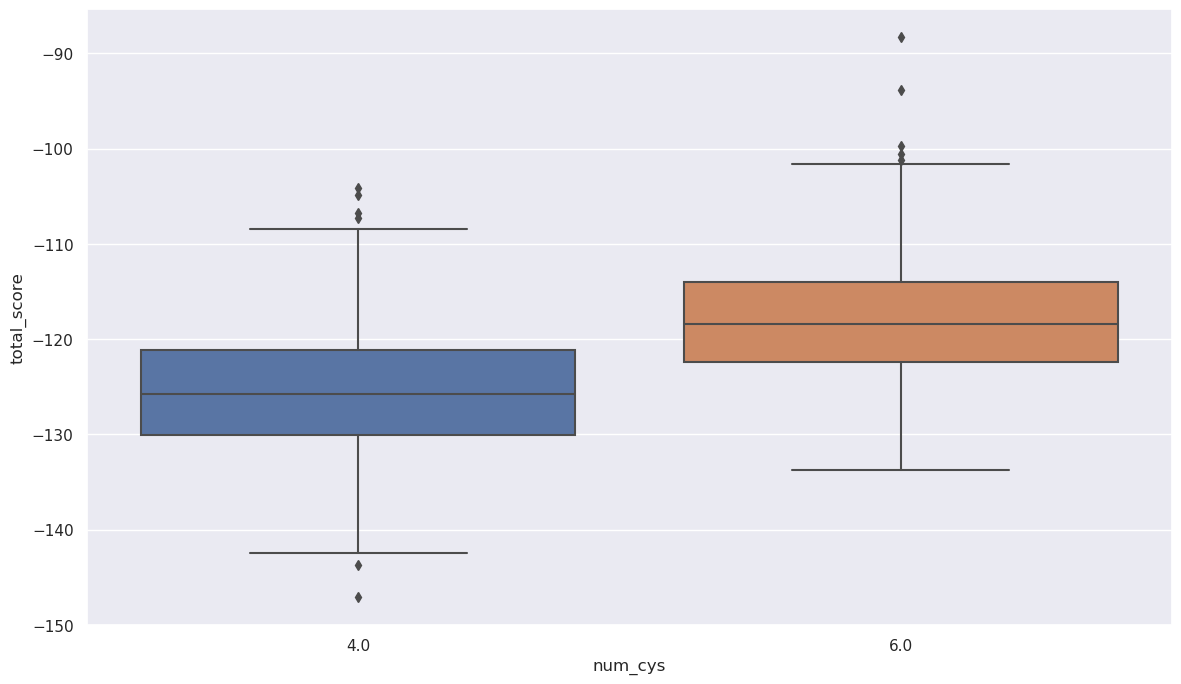

In [11]:
seaborn.boxplot(x="num_cys", y="total_score", data=result_frame)

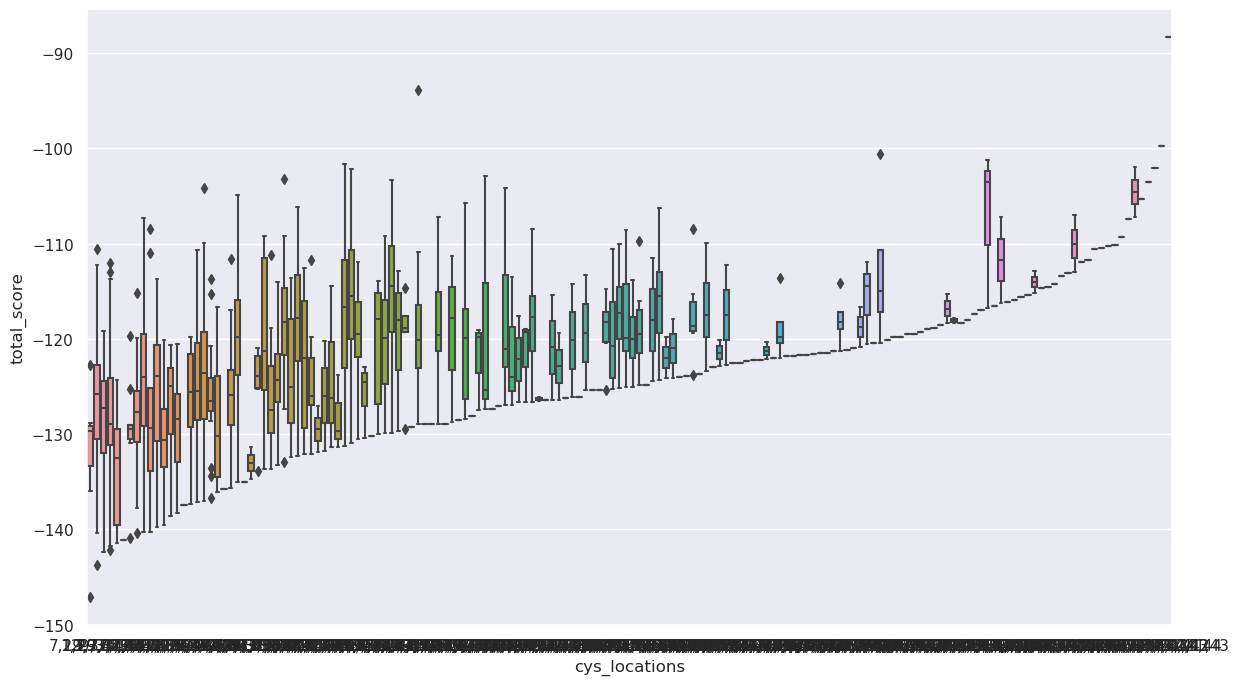

In [12]:
seaborn.boxplot(x="cys_locations", y="total_score", data=result_frame)

# Select 

Select the best model by total_Score for each inserted disulfide location, allowing us to test a variety of disulfide architectures.

In [13]:
best_by_location = to_dict(result_frame.groupby("cys_locations").head(1).reset_index(drop=True))

In [14]:
with open("EHEE.best_by_location.fasta", "w") as out:
    for entry in best_by_location:
        print(f">{entry['decoy']}", file=out)
        print(entry['sequence'], file=out)

In [15]:
!head EHEE.best_by_location.fasta

>30652025_EHEE_254_0001.pdb
GDYQLHTCNTSEEELKKLTETLRRRLQTECKLERHGDCYTITCHV
>30887334_EHEE_738_0001.pdb
GCKTLTFCGYDDEQAKKIQKDISKTVQRPVEVHKHGSCWEFHVCV
>30856927_EHEE_395_0001.pdb
GCTTWEFHNVDPNEVKKALRELSEKTGAECHLEQHGNTFHITCCV
>30884953_EHEE_269_0001_0004.pdb
GQKCVTFCGQDPREVKKIAEEIARRLQVPYEIRRHGSCITVCFKV
>30696637_EHEE_467_0001_0002.pdb
GTKTFTYDGVDPTEVDKSRERLEKELKTRCELECRGNQCHIHCHV


In [16]:
len(best_by_location)

162

# Visualize 
Spot check a collection of design model, highlighting inserted cystine locations.

In [17]:
view = py3Dmol.view(viewergrid=(3, 3), linked=False, width=900, height=900)
for i in range(9):
    view.addModel( pyrosetta.distributed.io.to_pdbstring(best_by_location[i]), "pdb", viewer=(i/3, i%3),)
    
view.setStyle({'cartoon':{'color':'spectrum'}})
view.setStyle({"resn": "CYS"}, {'stick': {}, 'cartoon':{'color':'spectrum'}} )
view.zoomTo()

PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2019.22+release.d8f9b4a90a8f2caa32948bacdb6e551591facd5f 2019-05-30T13:47:16] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol